# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

### Load features and labels into dataframe from csv file 

In [36]:
import zipfile
import os
import pandas as pd

with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


### Create test-train split

In [37]:
from sklearn.model_selection import train_test_split

y = data.label
X = data.drop('label', axis=1)

# Need to find logical nubmers for test_size and random_state and add this in the report. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### Plotting of training data 

<AxesSubplot:>

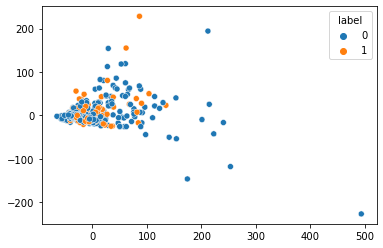

In [39]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import seaborn 

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

pca = decomposition.PCA(n_components=3)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)

<AxesSubplot:>

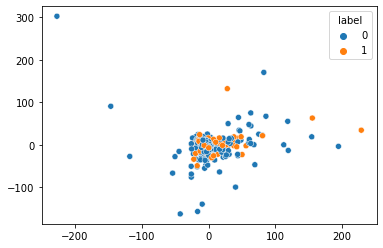

In [40]:
seaborn.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=y_train)

Inseperable after PCA => need to look into more complex relations between features, linear combinations of features is not enough here; need something more complex. 

### Preprocessing

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE

scaler = StandardScaler()
random_forest = RandomForestClassifier()
pca = PCA()

# "greedy_featureselection", SequentialFeatureSelector(estimator = random_forest, n_features_to_select=10, cv=2, n_jobs=-1))
#
pipe = Pipeline(steps=[('select', SelectKBest()), ("random_forest", random_forest)])

### Gridsearch for optimal hyperparameters Random Forest Classifer 

In [5]:
from sklearn.model_selection import GridSearchCV

parameters = {'select__k': [2, 5, 10, 20], 'random_forest__n_estimators': [50,100, 500, 1000]}
search = GridSearchCV(pipe, parameters, cv=3, scoring = 'f1', verbose=2)
search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ........random_forest__n_estimators=50, select__k=2; total time=   0.7s
[CV] END ........random_forest__n_estimators=50, select__k=2; total time=   0.5s
[CV] END ........random_forest__n_estimators=50, select__k=2; total time=   0.4s
[CV] END ........random_forest__n_estimators=50, select__k=5; total time=   0.4s
[CV] END ........random_forest__n_estimators=50, select__k=5; total time=   0.3s
[CV] END ........random_forest__n_estimators=50, select__k=5; total time=   0.4s
[CV] END .......random_forest__n_estimators=50, select__k=10; total time=   0.3s
[CV] END .......random_forest__n_estimators=50, select__k=10; total time=   0.3s
[CV] END .......random_forest__n_estimators=50, select__k=10; total time=   0.3s
[CV] END .......random_forest__n_estimators=50, select__k=20; total time=   0.4s
[CV] END .......random_forest__n_estimators=50, select__k=20; total time=   0.4s
[CV] END .......random_forest__n_estimators=50, 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('random_forest',
                                        RandomForestClassifier())]),
             param_grid={'random_forest__n_estimators': [50, 100, 500, 1000],
                         'select__k': [2, 5, 10, 20]},
             scoring='f1', verbose=2)

In [6]:
evaluation_grid= pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
evaluation_grid.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'], axis=1).head(5)

,param_random_forest__n_estimators,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,100,10,"{'random_forest__n_estimators': 100, 'select__...",0.320000,0.421053,0.440678,0.393910,0.052873,1
14,1000,10,"{'random_forest__n_estimators': 1000, 'select_...",0.280000,0.456140,0.385965,0.374035,0.072402,2
10,500,10,"{'random_forest__n_estimators': 500, 'select__...",0.274510,0.456140,0.363636,0.364762,0.074155,3
3,50,20,"{'random_forest__n_estimators': 50, 'select__k...",0.367347,0.392857,0.318182,0.359462,0.030992,4
11,500,20,"{'random_forest__n_estimators': 500, 'select__...",0.360000,0.436364,0.266667,0.354343,0.069394,5


### Complexity - Learning Curve

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

clf = search.best_estimator_


[learning_curve] Training set sizes: [ 66 214 363 512 661]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   1.4s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   36.9s finished


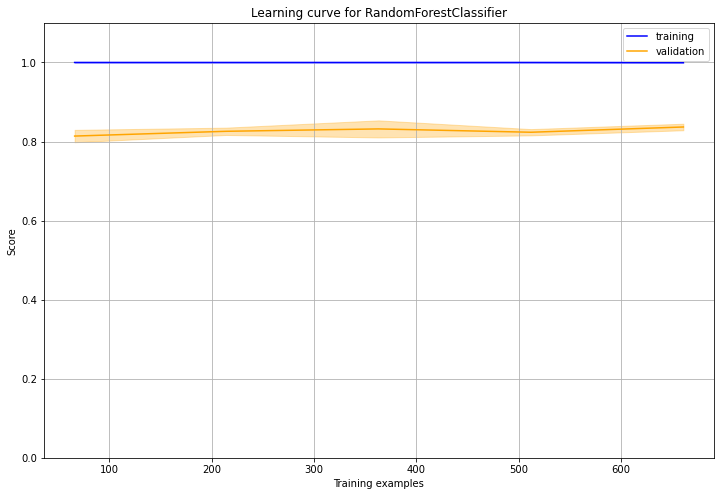

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(clf, X_train, y_train):
    train_size, train_scores, test_scores = learning_curve(clf, X, y, verbose=2)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12, 8))
    plt.title(f'Learning curve for {str(type(clf[-1])).split(".")[-1][:-2]}')
    plt.plot(train_size, train_mean, color='b', label='training')
    plt.plot(train_size, test_mean, color='orange', label='validation')

    plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
    plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.3)
    
    plt.grid()
    plt.ylim([0, 1.1])
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

plot_learning_curve(clf, X, y)

### Evaluation of classifier 

In [138]:
from sklearn.metrics import f1_score, confusion_matrix
best_clf = search.best_estimator_
y_pred = best_clf.predict(X_test)
f1_score(y_test, y_pred)


0.25396825396825395

In [139]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['normal', 'abnormal'], index= ['normal', 'abnormal'])

,normal,abnormal
normal,218,9
abnormal,38,8
